In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
AUTOTUNE = tf.data.experimental.AUTOTUNE
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256,256, 3])
    return image
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
print(monet_ds)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [2]:
def generator_model():
    model =tf.keras.Sequential()
    model.add(layers.Input(shape=(256,256,3)))
    model.add(layers.Conv2DTranspose(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(512,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3,4,padding='same',activation='sigmoid'))
    return model

In [3]:
generator_monet=generator_model()
generator_photo=generator_model()
generated_image=generator_monet(next(iter(monet_ds)),training=False)

TensorShape([1, 256, 256, 3])

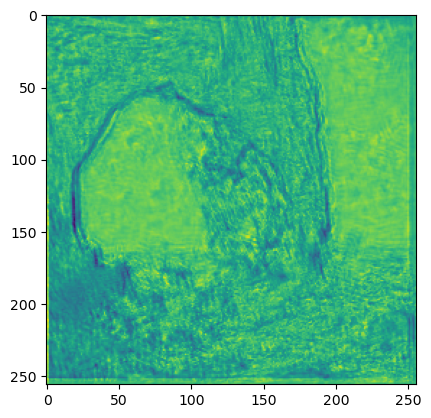

In [4]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0,:,:,0])
generated_image.shape

In [5]:
from tensorflow.keras.models import Model
def discrimatior_model():
    model =tf.keras.Sequential()
    model.add(layers.Input(shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=(1,1),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128,4,strides=(1,1),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256,4,strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.ZeroPadding2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
discrimator=discrimatior_model()
print(discrimator(generated_image))

tf.Tensor([[0.04839832]], shape=(1, 1), dtype=float32)


In [7]:
monet_discrimator=discrimatior_model()
photo_discrimator=discrimatior_model()

In [8]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    loss=real_loss+fake_loss
    return loss
def generator_loss(fake):
    return cross_entropy(tf.zeros_like(fake),fake)
monet_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
monet_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [15]:
import keras
class CycleGan(keras.Model):
    def __init__(self,generator_monet,generator_photo,monet_discrimator,photo_discrimator,lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = generator_monet
        self.p_gen = generator_photo
        self.m_disc = monet_discrimator
        self.p_disc = photo_discrimator
        self.lambda_cycle = lambda_cycle
    def compile(self,generator_loss,discrimator_loss,monet_generator_optimizer,monet_discriminator_optimizer,photo_generator_optimizer,photo_discriminator_optimizer):
        super(CycleGan, self).compile()
        self.gen_loss_fn=generator_loss
        self.disc_loss_fn=discrimator_loss
        self.monet_generator_optimizer=monet_generator_optimizer
        self.monet_discriminator_optimizer=monet_discriminator_optimizer
        self.photo_generator_optimizer=photo_generator_optimizer
        self.photo_discriminator_optimizer=photo_discriminator_optimizer
    def train_image(self,batch_data):
        real_monet,real_photo=batch_data
        with tf.GradientTape(persistent=True) as gen_tape,tf.GradientTape(persistent=True) as disc_tape:
            fake_monet=self.m_gen(real_photo,training=True)
            cycled_photo=self.p_gen(fake_monet,training=True)
            
            fake_photo=self.p_gen(real_monet,training=True)
            cycled_monet=self.m_gen(fake_photo,training=True)
            
            same_monet=self.m_gen(real_monet,training=True)
            same_photo=self.p_gen(real_photo,training=True)
            
            real_monet_output=self.m_disc(same_monet,training=True)
            fake_monet_output=self.m_disc(cycled_monet,training=True)
            
            real_photo_output=self.p_disc(same_photo,training=True)
            fake_photo_output=self.p_disc(cycled_photo,training=True)
            
            monet_gen_loss=self.gen_loss(fake_monet_output)
            photo_gen_loss=self.gen_loss(fake_photo_output)
            
            monet_disc_loss=self.disc_loss(real_monet_output,fake_monet_output)
            photo_disc_loss=self.disc_loss(real_photo_output,fake_photo_output)
        gradients_monet_generator=gen_tape.gradient(monet_gen_loss,generator_monet.trainable_variables)
        gradients_photo_generator=gen_tape.gradient(photo_gen_loss,generator_photo.trainable_variables)
        gradients_monet_discrimator=disc_tape.gradient(monet_disc_loss,monet_discrimator.trainable_variables)
        gradients_photo_discrimator=disc_tape.gradient(photo_disc_loss,photo_discrimator.trainable_variables)
        
        self.monet_generator_optimizer.apply_gradients(zip(gradients_monet_generator,generator_monet.trainable_variables))
        self.monet_discriminator_optimizer.apply_gradients(zip(gradients_monet_discrimator,monet_discrimator.trainable_variables))
        self.photo_generator_optimizer.apply_gradients(zip(gradients_photo_generator,generator_photo.trainable_variables))
        self.photo_discriminator_optimizer.apply_gradients(zip(gradients_photo_discrimator,photo_discrimator.trainable_variables))


In [18]:

cycle_gan_model = CycleGan(
        generator_monet, generator_photo, monet_discrimator, photo_discrimator
    )

cycle_gan_model.compile(
        monet_generator_optimizer = monet_generator_optimizer,
        photo_generator_optimizer = photo_generator_optimizer,
        monet_discriminator_optimizer = monet_discriminator_optimizer,
        photo_discriminator_optimizer = photo_discriminator_optimizer,
        generator_loss = generator_loss,
        discrimator_loss = discriminator_loss)

In [19]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


NotImplementedError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 585, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'cycle_gan_4' (type CycleGan).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'cycle_gan_4' (type CycleGan):
      • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
      • training=True
      • mask=None


In [ ]:
pred=generator_monet(next(iter(photo_ds)))


In [ ]:
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(100, 100))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)